# Project Optimal Transport
Ce fichier est mon implémentation personnelle de l'article [Wasserstein Distributionally Robust Kalman Filtering](https://papers.nips.cc/paper/8067-wasserstein-distributionally-robust-kalman-filtering.pdf) fait dans le cadre du projet d'optimal transport du MVA.

_Auteur :_ Ludovic De Matteïs

_Encadrant :_ Gabriel Peyré

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import eigh as largest_eigh
#!pip install control
import control as ct
from scipy.linalg import sqrtm
from numpy.linalg import matrix_power as mat_pow
import pandas as pd
import time
import cvxpy as cp
from matplotlib import cm

def smooth(arr):
    window_size = 20
    numbers_series = pd.Series(arr)
    windows = numbers_series.rolling(window_size)
    moving_averages = windows.mean()
    moving_averages_list = moving_averages.tolist()
    plot_array = moving_averages_list[window_size - 1:]
    return(plot_array)

## Replication of the paper results

### Algorithm 1

In [2]:
def bissection(cov_mat, D, r, tol): # PAS TOUCHE, CA MARCHE !!! 
    ''' 
    Inputs : 
        cov_mat : Covariance matrix, postive definite
        D : Gradient matrix, positive semi-definite
        r : Wassertein radius, scalar strictly positive
        tol : Tolerance, scalar strictly positive
    Output :
        L
    '''
    d = np.shape(D)[0]
    h = lambda inv_D : r**2 - np.sum(np.sum(np.multiply(cov_mat, mat_pow(np.eye(d) - inv_D, 2)))) # TODO : Check that this definition gives the correct results
    
    # Intialize variables used for the stopping criterion
    delta = np.inf
    h_val = 0
    
    # Finding the bisection intervals
    eigen_val, eigen_vect = largest_eigh(D, eigvals_only=False, subset_by_index=[d-1, d-1]) # Get the largest eigenvalue of the gradient matrix and a corresponding eigenvector

    LB = float(eigen_val*(1+np.sqrt(eigen_vect.T@cov_mat@eigen_vect)/r))
    UB = float(eigen_val*(1+np.sqrt(np.trace(cov_mat))/r))
    # Main loop
    while (delta >= tol) or (h_val<=0):
        gamma = (UB + LB)/2
        inv_mat = gamma*np.linalg.inv(gamma*np.eye(d) - D) # I do this computation here in order to fasten a bit the programm
        L = inv_mat@cov_mat@inv_mat
        h_val = h(inv_mat)
        if h_val<0:
            LB = gamma
        else:
            UB = gamma
        delta = gamma*(r**2-np.trace(cov_mat)) - float(np.dot(L.flatten(), D.flatten().T)) + gamma*float(np.dot(inv_mat.flatten(), cov_mat.flatten().T))
    return(L)

### Algorithm 2

In [3]:
default_ops = {"iter_max" : 1000,
               "bi_tol" : 1e-2,
               "tol" : 1e-4}

def Frank_wolfe(mu, Sigma, rho, x_dim, opts=default_ops):
    '''
    Inputs : 
        mu : Mean vector of the prior distribution
        Sigma : Covariance matrix of the prior distribution
        r : Wasserstein ambiguity set radius
        x_dim : Dimension of the state space
        opts : Dictionary containing the parameters for Frank-Wolfe algorithm
            opts["iter_max"] : Maximum number of iterations
            opts["bi_tol"] : Tolerance of the bisection algorithm
            opts["tol"] : Relative duality gap as a stopping criteria
    Outputs:
        phi_star : A list containing parameters of the optimal affine decision rule
            phi_star[0] : Slope of the optimal decision rule
            phi_star[1] : Intercept of the optimal decision rule
        Q_star : A list containing the parameters of the least favorable prior
            Q_star[0] : Mean vector
            Q_star[1] : Covariance matrix
        obj : List of the objective values along the iterations
        res : List of the dual optimality gap along the iterations
    '''
    
    # Parameters
    n = x_dim
    iter_max = opts["iter_max"]
    bi_tol = opts["bi_tol"]
    tol = opts["tol"]
    
    # Auxilary functions
    ## Reminder that S is of size n+m*n+m (n : number of states, m : number of observations)
    G_ = lambda S : S[:n, n:]@np.linalg.inv(S[n:, n:])
    f_ = lambda S, G : np.trace(S[:n, :n] - G@S[n:, :n])
    grad_f_ = lambda G : np.concatenate((np.eye(n), -G), axis=1).T@np.concatenate((np.eye(n), -G), axis=1)
    
    # Initialize
    S = Sigma
    obj = np.zeros((iter_max, 1))
    res = np.zeros((iter_max, 1))
    phi_star = [0, 0]
    Q_star = [0, 0]
    
    # I do not consider the case where the radius is zero
    
    for i in range(iter_max):
        G = G_(S)
        obj_current = f_(S, G)
        
        # Computing partial derivatives and solving the algebraic equation
        D = grad_f_(G)
        L = bissection(Sigma, D, rho, bi_tol)
        # Check the optimality conditions 
        res_current = float(np.abs((L-S).flatten()@D.flatten().T))
        if res_current / obj_current < tol:
            break
        # Updating the current solutions
        alpha = 2/(2+i)
        S = (1-alpha)*S + alpha*L

        # Store results
        if i != 0:
            obj[i] = obj_current
            res[i] = res_current
            
    if i < iter_max:
        obj = obj[:i]
        res = res[:i]
        
    phi_star[0] = G
    phi_star[1] = mu[0:n] - G*mu[-1]
    Q_star[1] = S
    Q_star[0] = mu

    return(phi_star, Q_star, obj, res)

### Algorithm 3

In [4]:
def predict(x_prev, V_prev, sys):
    A_aug = np.concatenate((sys.A, sys.C@sys.A))
    B_aug = np.concatenate((sys.B, sys.C@sys.B + sys.D))
    mu_t = A_aug @ x_prev
    Sigma_t = A_aug @ V_prev @ A_aug.T + B_aug @ B_aug.T
    return(mu_t, Sigma_t)

def update(mu_t, Sigma_t, r, y, x_dim, opts):
    phi_star, Q_star, _, _ = Frank_wolfe(mu_t, Sigma_t, r, x_dim, opts)
    G_t = phi_star[0]
    S_t = Q_star[1]
    V_t = S_t[:x_dim, :x_dim] - G_t @ S_t[x_dim:, :x_dim]
    x_hat_t = G_t @ (y - mu_t[x_dim:]) + mu_t[:x_dim]
    return(x_hat_t, V_t, G_t, S_t)

def WKF(sys, r, Y, x0, V0, opts = default_ops):
    '''
    Wasserstein Kalman filter
    Considering the following linear system (for simplicity, we consider invariant systems)
        x_{t+1} = A_t x_t + B_t v_t
        y_t = C_t x_t + D_t v_t
    where x_t is the unobserved state of the system at time step t, y_t the observed output
        and v_t the stochastic driving noise of the system. 
    We denote T the total number of time steps
        
    Inputs :
        sys : control.StateSpace object containing the state space model representation
        r : A scalar or a vector with size T, defining the radius of the ambiguity set at time step t in [0, T-1]
        Y : Matrix of the observed outputs, size m*T
        x0 : initial state estimate
        V0 : initial covariance matrix
        opts : Parameters of Frank-Wolfe algorithm
    Outputs :
        x_hat : A matrix of size n*T whose i-th column is the estimated state at time step i
        V : A matrix of size n*n*T whose block [:,:,i] is the estimate of the covariance matrix at time step i
        G : A matrix of size n*m*T whose block [:,:,i] is the gain at time step i
        S : A matrix of size d*d*T whose block [:,:,i] is the least favorable covariance matrix at time step i
    '''
    m, T = np.shape(Y)
    n = len(x0)
    d = n + m
    
    x_prev = x0
    V_prev = V0
    x_hat = np.zeros((n, T))
    V = np.zeros((n, n, T))
    G = np.zeros((n, m, T))
    S = np.zeros((d, d, T))
    
    for t in range(T):
        mu_t, Sigma_t = predict(x_prev, V_prev, sys)
        if type(r) is np.float64 or type(r) is float:
            r_t = r
        else:
            r_t = r[t]
        #print(f"\t Running update {t+1}/{T}")
        x_hat_t, V_t, G_t, S_t = update(mu_t, Sigma_t, r_t, Y[:,t], len(x0), opts)
        x_hat[:, t] = x_hat_t.reshape(n,)
        V[:, :, t] = V_t
        G[:, :, t] = G_t
        S[:, :, t] = S_t

        x_prev = x_hat_t
        V_prev = V_t
    return(x_hat, V, G, S)

### Data generation

In [5]:
def generate_data(sys, x0, T, coeff, is_TV):
    m, n = np.shape(sys.C)
    d = m + n  
    y0 = float(sys.C@x0 + sys.D@np.random.normal(size=(d, 1)))
    x_prev = x0
    x = np.zeros((n, T))
    y = np.zeros((m, T))
    #Delta = np.random.uniform(-1, 1) # uniform on -1, 1
    Delta = np.random.normal(0, 1)
    A_purt = sys.A + np.matrix([[0, coeff * Delta],[0 ,0]])
    for t in range(T):
        x[:, t] = (A_purt@x_prev + sys.B@np.random.normal(size=(d, 1))).reshape(n,)
        y[:, t] = (sys.C@x[:,t] + sys.D@np.random.normal(size=(d, 1))).reshape(m,)
        x_prev = x[:,t][:, None]
        if is_TV:
            Delta = np.random.uniform(-1, 1) # uniform on -1, 1
            A_purt = sys.A + np.matrix([[0, coeff * Delta], [0, 0]])
    return(x, y, y0)

## Personnal implementation

### Adapted Algorithm 3

In [6]:
def frobenius_problem_solver(Sigma_t, r, x_dim):
    n = x_dim
    m = len(Sigma_t)-x_dim
    d = n + m
    sigma = float(largest_eigh(Sigma_t, eigvals_only=True, subset_by_index=[0, 0])) # Get the lowest eigenvalue of the matrix
    Sxx = cp.Variable((n, n), symmetric=True)
    Syy = cp.Variable((m, m), symmetric=True)
    Sxy = cp.Variable((n, m))
    Syx = cp.Variable((m, n))
    
    objective = cp.Maximize(cp.trace(Sxx - cp.matrix_frac(Syx, Syy)))
    constraints = [cp.bmat([[Sxx, Sxy],[Syx, Syy]]) >> 0] + \
                  [Sxx >> 0] + \
                  [Syy >> 0] + \
                  [Sxy.T == Syx] + \
                  [cp.bmat([[Sxx, Sxy],[Syx, Syy]]) >> sigma*np.eye(d)] + \
                  [cp.norm(cp.bmat([[Sxx, Sxy],[Syx, Syy]]) - Sigma_t, "fro")<=r]

    prob = cp.Problem(objective, constraints)
    prob.solve()
    return(Sxx.value, Sxy.value, Syy.value, Syx.value)

def update_fro(mu_t, Sigma_t, r, y_t, x_dim):
    S_t_xx, S_t_xy, S_t_yy, S_t_yx = frobenius_problem_solver(Sigma_t, r, x_dim)
    V_t = S_t_xx - S_t_xy@np.linalg.inv(S_t_yy)@S_t_yx
    x_hat_t = S_t_xy@np.linalg.inv(S_t_yy)@(y_t-mu_t[x_dim:]) + mu_t[:x_dim]
    S = np.vstack((np.hstack((S_t_xx, S_t_xy)), np.hstack((S_t_yx, S_t_yy))))
    return(x_hat_t, V_t, S)

def FKF(sys, r, Y, x0, V0):
    '''
    Frobenius Kalman filter
    Considering the following linear system (for simplicity, we consider invariant systems)
        x_{t+1} = A_t x_t + B_t v_t
        y_t = C_t x_t + D_t v_t
    where x_t is the unobserved state of the system at time step t, y_t the observed output
        and v_t the stochastic driving noise of the system. 
    We denote T the total number of time steps
        
    Inputs :
        sys : control.StateSpace object containing the state space model representation
        r : A scalar or a vector with size T, defining the radius of the ambiguity set at time step t in [0, T-1]
        Y : Matrix of the observed outputs, size m*T
        x0 : initial state estimate
        V0 : initial covariance matrix
    Outputs :
        x_hat : A matrix of size n*T whose i-th column is the estimated state at time step i
        V : A matrix of size n*n*T whose block [:,:,i] is the estimate of the covariance matrix at time step i
        S : A matrix of size d*d*T whose block [:,:,i] is the least favorable covariance matrix at time step i
    '''
    m, T = np.shape(Y)
    n = len(x0)
    d = n + m
    
    x_prev = x0
    V_prev = V0
    x_hat = np.zeros((n, T))
    V = np.zeros((n, n, T))
    S = np.zeros((d, d, T))
    
    for t in range(T):
        mu_t, Sigma_t = predict(x_prev, V_prev, sys)
        if type(r) is np.float64 or type(r) is float:
            r_t = r
        else:
            r_t = r[t]
        x_hat_t, V_t, S_t = update_fro(mu_t, Sigma_t, r_t, Y[:,t], len(x0))
        x_hat[:, t] = x_hat_t.reshape(n,)
        V[:, :, t] = V_t
        S[:, :, t] = S_t

        x_prev = x_hat_t
        V_prev = V_t
    return(x_hat, V, S)

### Testing

#### Comparing errors of WKF and FKF for radius of different sizes


Running iteration 1
	 Running for radius 0
	 Running for radius 1
	 Running for radius 2
	 Running for radius 3
	 Running for radius 4
	 Running for radius 5
	 Running for radius 6
	 Running for radius 7
	 Running for radius 8
	 Running for radius 9

Running iteration 2
	 Running for radius 0
	 Running for radius 1
	 Running for radius 2
	 Running for radius 3
	 Running for radius 4
	 Running for radius 5
	 Running for radius 6
	 Running for radius 7
	 Running for radius 8
	 Running for radius 9

Running iteration 3
	 Running for radius 0
	 Running for radius 1
	 Running for radius 2
	 Running for radius 3
	 Running for radius 4
	 Running for radius 5
	 Running for radius 6
	 Running for radius 7
	 Running for radius 8
	 Running for radius 9
Done
0.21544346900318834
100.0


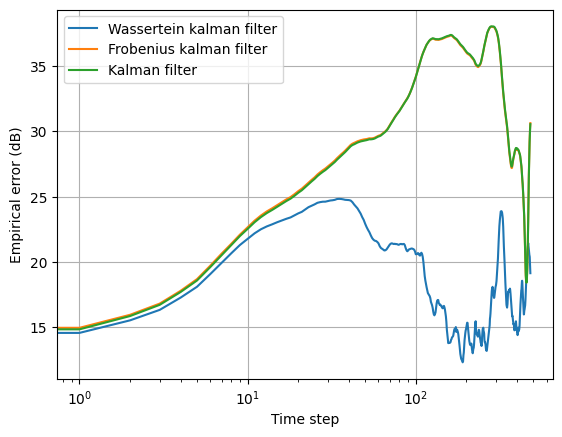


Running iteration 1
	 Running for radius 0
	 Running for radius 1
	 Running for radius 2
	 Running for radius 3
	 Running for radius 4
	 Running for radius 5
	 Running for radius 6
	 Running for radius 7
	 Running for radius 8
	 Running for radius 9

Running iteration 2
	 Running for radius 0
	 Running for radius 1
	 Running for radius 2
	 Running for radius 3
	 Running for radius 4
	 Running for radius 5
	 Running for radius 6
	 Running for radius 7
	 Running for radius 8
	 Running for radius 9

Running iteration 3
	 Running for radius 0
	 Running for radius 1
	 Running for radius 2
	 Running for radius 3
	 Running for radius 4
	 Running for radius 5
	 Running for radius 6
	 Running for radius 7
	 Running for radius 8
	 Running for radius 9
Done
0.21544346900318834
100.0


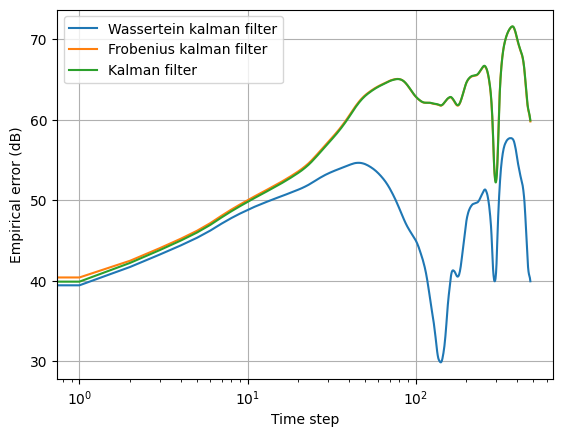


Running iteration 1
	 Running for radius 0
	 Running for radius 1
	 Running for radius 2
	 Running for radius 3
	 Running for radius 4
	 Running for radius 5
	 Running for radius 6
	 Running for radius 7
	 Running for radius 8
	 Running for radius 9

Running iteration 2
	 Running for radius 0
	 Running for radius 1
	 Running for radius 2
	 Running for radius 3
	 Running for radius 4
	 Running for radius 5
	 Running for radius 6
	 Running for radius 7
	 Running for radius 8
	 Running for radius 9

Running iteration 3
	 Running for radius 0
	 Running for radius 1
	 Running for radius 2
	 Running for radius 3
	 Running for radius 4
	 Running for radius 5
	 Running for radius 6
	 Running for radius 7
	 Running for radius 8
	 Running for radius 9
Done
0.21544346900318834
0.01


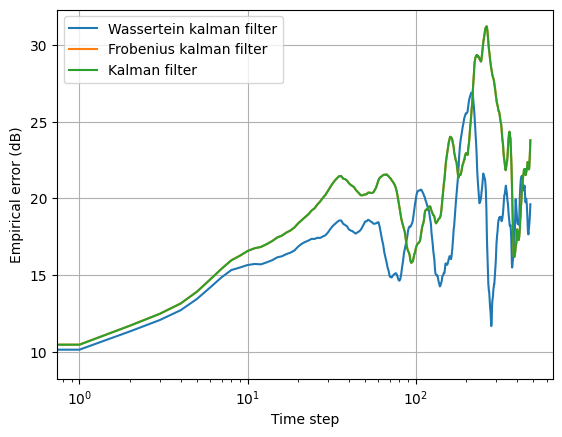


Running iteration 1
	 Running for radius 0
	 Running for radius 1
	 Running for radius 2
	 Running for radius 3
	 Running for radius 4
	 Running for radius 5
	 Running for radius 6
	 Running for radius 7
	 Running for radius 8
	 Running for radius 9

Running iteration 2
	 Running for radius 0
	 Running for radius 1
	 Running for radius 2
	 Running for radius 3
	 Running for radius 4
	 Running for radius 5
	 Running for radius 6
	 Running for radius 7
	 Running for radius 8
	 Running for radius 9

Running iteration 3
	 Running for radius 0
	 Running for radius 1
	 Running for radius 2
	 Running for radius 3
	 Running for radius 4
	 Running for radius 5
	 Running for radius 6
	 Running for radius 7
	 Running for radius 8
	 Running for radius 9
Done
0.21544346900318834
0.01


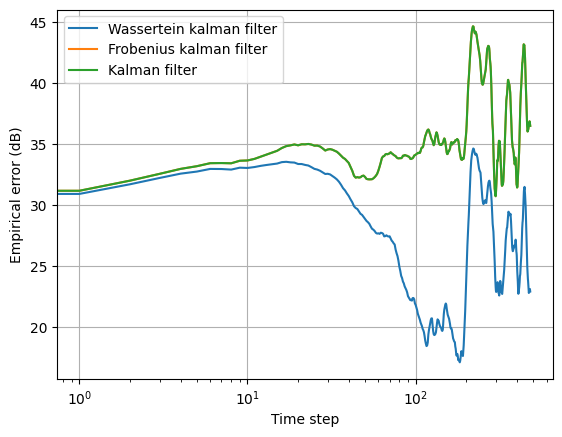

In [20]:
#np.random.seed(12345)
n = 2
m = 1
d = n + m
A = np.matrix('0.9802, 0.0196; 0, 0.9802', dtype=float)
Q = np.matrix('1.9608, 0.0195; 0.0195, 1.9605', dtype=float)
R = 1
B = np.concatenate((sqrtm(Q), np.zeros((2,1))), axis=1)
C = np.array([1, -1])
D = np.array([0, 0, 1])

sys = ct.StateSpace(A, B, C, D)

run_count = 3
T = 500

x0 = np.zeros((n, 1))
V0 = np.eye(n)
#all_r = np.arange(1,4,0.5)*1e1
all_r = np.logspace(-2, 2, 10)

list_TV = [False, False, True, True]
list_coeff = [1, 10, 1, 10]

execution_time = np.zeros((2, len(all_r), len(list_TV), run_count))
kalman_time = np.zeros((len(list_TV), run_count))


# Initialisation
err_KF = np.zeros((T, run_count, 1, len(list_TV)))
err_WKF = np.zeros((T, run_count, len(all_r), len(list_TV)))
err_FKF = np.zeros((T, run_count, len(all_r), len(list_TV)))

for j in range(len(list_TV)):
    # Parameters
    is_TV = list_TV[j]   # Time varying perturbations
    coeff = list_coeff[j]       # Amplitude of the perturbation

    for i in range(run_count):
        print(f"\nRunning iteration {i+1}")
        x, y, y0 = generate_data(sys, x0, T, coeff, is_TV)
        for k in range(len(all_r)):
            print(f"\t Running for radius {k}")
            start = time.time()
            x_hat, _, _, _ = WKF(sys, all_r[k], y, x0, V0)
            execution_time[0, k, j, i] = time.time() - start
            err_WKF[:, i, k, j] = np.sum((x-x_hat)**2, 0)

            start = time.time()
            x_hat_fro, V_fro, S_fro = FKF(sys, all_r[k], y, x0, V0)
            execution_time[1, k, j, i] = time.time() - start
            err_FKF[:, i, k, j] = np.sum((x-x_hat_fro)**2, 0)
            
        start = time.time()
        x_hat_KF, V_KF, S_KF = FKF(sys, 0.0, y, x0, V0)
        kalman_time[j, i] = time.time()-start
        err_KF[:, i, 0, j] = np.sum((x-x_hat_KF)**2, 0)
    print("Done")
    
    ## TODO Change
    tmp = np.mean(np.mean(err_WKF[:, :, :, j], 1), 0)
    k_rho = np.argmin(tmp)
    print(all_r[k_rho])
    log_err_WKF = 10*np.log10(np.mean(err_WKF[:, :, k_rho, j], 1))
    
    tmp = np.mean(np.mean(err_FKF[:, :, :, j], 1), 0)
    k_rho = np.argmin(tmp)
    print(all_r[k_rho])
    log_err_FKF = 10*np.log10(np.mean(err_FKF[:, :, k_rho, j], 1))
    
    log_err_KF = 10*np.log10(np.mean(err_KF[:, :, 0, j], 1))

    fig = plt.figure()
    plt.plot(smooth(log_err_WKF), label='Wassertein kalman filter')
    plt.plot(smooth(log_err_FKF), label='Frobenius kalman filter')
    plt.plot(smooth(log_err_KF), label='Kalman filter')
    plt.xscale('log')
    plt.grid()
    plt.legend()
    plt.xlabel("Time step")
    plt.ylabel("Empirical error (dB)")
    plt.savefig(f"Empirical_error_compare_{is_TV}_{coeff}.png")
    plt.show()

#### Influence of the radius of the empirical error

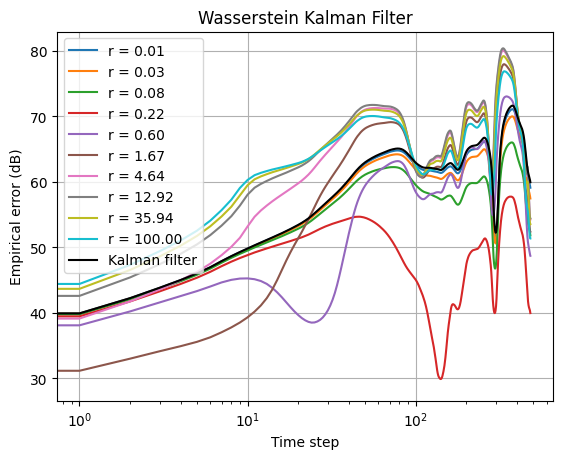

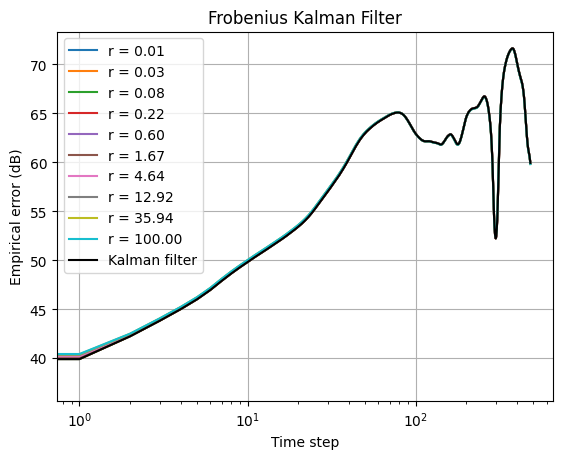

In [22]:
log_err_KF = 10*np.log10(np.mean(err_KF[:, :, 0, 1], 1))

fig = plt.figure()
for k in range(len(all_r)):
    log_err_WKF = 10*np.log10(np.mean(err_WKF[:, :, k, 1], 1))
    plt.plot(smooth(log_err_WKF), label=f'r = {all_r[k]:.2f}')
plt.plot(smooth(log_err_KF), 'k-', label='Kalman filter')
plt.xscale('log')
plt.grid()
plt.legend()
plt.xlabel("Time step")
plt.ylabel("Empirical error (dB)")
plt.title("Wasserstein Kalman Filter")
plt.savefig(f"radius_compare_wasserstein")
plt.show()

fig = plt.figure()
for k in range(len(all_r)):
    log_err_FKF = 10*np.log10(np.mean(err_FKF[:, :, k, 1], 1))
    plt.plot(smooth(log_err_FKF), label=f'r = {all_r[k]:.2f}')
plt.plot(smooth(log_err_KF), 'k-', label='Kalman filter')
plt.xscale('log')
plt.grid()
plt.legend()
plt.xlabel("Time step")
plt.ylabel("Empirical error (dB)")
plt.title("Frobenius Kalman Filter")
plt.savefig(f"radius_compare_frobenius")
plt.show()

(2, 10, 4, 3)
(2, 10)
[1.00000000e-02 2.78255940e-02 7.74263683e-02 2.15443469e-01
 5.99484250e-01 1.66810054e+00 4.64158883e+00 1.29154967e+01
 3.59381366e+01 1.00000000e+02]


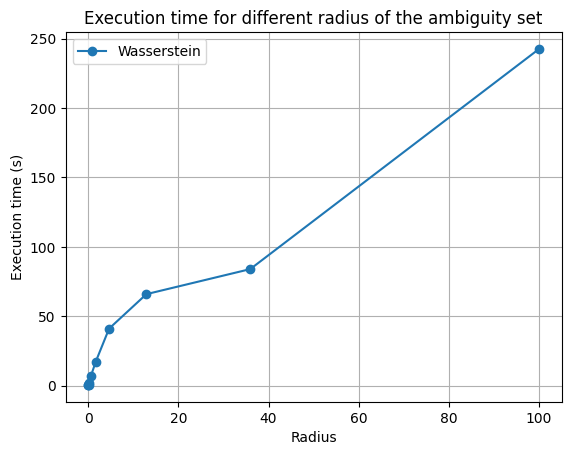

In [27]:
print(np.shape(execution_time))
time_radius = np.mean(np.mean(execution_time, 2), 2)
print(np.shape(time_radius))
print(all_r)

plt.figure()
plt.plot(all_r, time_radius[0, :], '-o', label="Wasserstein")
#plt.plot(all_r, time_radius[1, :], '-o', label="Frobenius")
#plt.hlines(np.mean(np.mean(kalman_time)),0, 1, 'k', label="Kalman filter")
plt.grid()
plt.legend()
#plt.xlim([0, 1])
plt.xlabel("Radius")
plt.ylabel("Execution time (s)")
plt.title("Execution time for different radius of the ambiguity set")
plt.savefig("Execution_time_radius_wass.png")
plt.show()


#### Plotting Wasserstein ball and Frobenius ball

/tmp/ipykernel_15322/1371906314.py:6: RuntimeWarning: invalid value encountered in sqrt
  Z = np.sqrt(np.multiply(X,Y)-np.power(((X+Y-0.1)/(2*np.sqrt(2))),4))


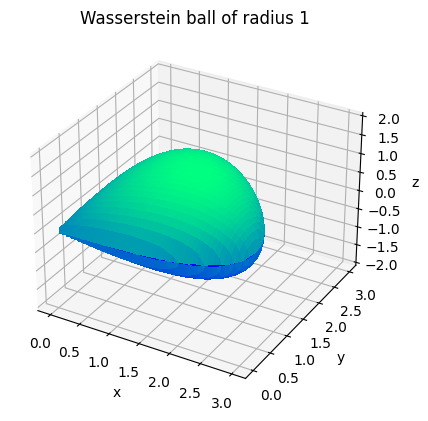

In [96]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import eigh as largest_eigh
#!pip install control
import control as ct
from scipy.linalg import sqrtm
from numpy.linalg import matrix_power as mat_pow
import pandas as pd
import time
import cvxpy as cp
from matplotlib import cm

# plt.rcParams['text.usetex'] = True

# Wassestein ball of radius 1
x = np.arange(0, 4, 0.001)
y = np.arange(0, 4, 0.001)

[X,Y] = np.meshgrid(x,y);
Z = np.sqrt(np.multiply(X,Y)-np.power(((X+Y-1)/(2*np.sqrt(2))),4))
Z = np.concatenate((Z,-Z))
Y = np.concatenate((Y,Y))
X = np.concatenate((X,X))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap=cm.winter, linewidth=0, antialiased=False)
ax.set_xlabel('Sxx')
ax.set_ylabel('Syy')
ax.set_zlabel('Sxy')
ax.set_zlim([-2, 2])
ax.set_title('Wasserstein ball of radius 1')
plt.savefig("Wasserstein_ball.png")
plt.show()

# Wassestein ball of radius 0.1
x = np.arange(0, 4, 0.001)
y = np.arange(0, 4, 0.001)

Z = np.sqrt(np.multiply(X,Y)-np.power(((X+Y-1)/(2*np.sqrt(2))),4))
Z = np.concatenate((Z,-Z))
Y = np.concatenate((Y,Y))
X = np.concatenate((X,X))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap=cm.winter, linewidth=0, antialiased=False)
ax.set_xlabel('Sxx')
ax.set_ylabel('Syy')
ax.set_zlabel('Sxy')
ax.set_zlim([-2, 2])
ax.set_title('Wasserstein ball of radius 0.1')
plt.savefig("Wasserstein_ball_bis.png")
plt.show()

# Frobenius Ball
x = np.arange(0, 2, 0.01)
y = np.arange(0, 2, 0.01)
X, Y, Z = np.zeros((200, 200)), np.zeros((200, 200)), np.zeros((200, 200))
r = 1
for i, xi in enumerate(x):
    for j, yj in enumerate(y):
        X[i, j] = xi
        Y[i, j] = yj
        zij = np.sqrt((1/2)*(r-(xi-1)**2-(yj-1)**2))
        Z[i, j] = float(zij)

Z = np.concatenate((Z,-Z))
Y = np.concatenate((Y,Y))
X = np.concatenate((X,X))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap=cm.winter, linewidth=0, antialiased=False)

ax.set_xlabel('Sxx')
ax.set_ylabel('Syy')
ax.set_zlabel('Sxy')
ax.set_zlim([-1, 1])
ax.set_title(f'Frobenius ball of radius {r}')
plt.savefig("Frobenius_ball.png")
plt.show()

# Frobenius Ball
x = np.arange(0, 2, 0.01)
y = np.arange(0, 2, 0.01)
X, Y, Z = np.zeros((200, 200)), np.zeros((200, 200)), np.zeros((200, 200))
r = 0.1
for i, xi in enumerate(x):
    for j, yj in enumerate(y):
        X[i, j] = xi
        Y[i, j] = yj
        zij = np.sqrt((1/2)*(r-(xi-1)**2-(yj-1)**2))
        Z[i, j] = float(zij)

Z = np.concatenate((Z,-Z))
Y = np.concatenate((Y,Y))
X = np.concatenate((X,X))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap=cm.winter, linewidth=0, antialiased=False)

ax.set_xlabel('Sxx')
ax.set_ylabel('Syy')
ax.set_zlabel('Sxy')
ax.set_zlim([-1, 1])
ax.set_title(f'Frobenius ball of radius {r}')
plt.savefig("Frobenius_ball_bis.png")
plt.show()